
# Comomentum Sector ETF Phase B

## Objective
- 9セクターETF（XLB〜XLY）で Comomentum 論文の主要命題を再現する。
- 実施範囲: 主要命題、頑健性拡張（6本）、投資主体拡張、ETF内外部市場拡張。
- 重要制約: 特徴量は時点 `t` まで、予測対象は `t+1` 以降（リーク禁止）。



## Setup


In [1]:

from __future__ import annotations

from pathlib import Path
from datetime import datetime
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

ROOT = Path('/Users/kencharoff/workspace/projects/momentum/p02_comomentum')
DATA_PATH = ROOT / 'data' / 'prices.csv'
SUMMARY_PATH = ROOT / 'outputs' / 'phase_b' / 'summary.md'
SUMMARY_PATH.parent.mkdir(parents=True, exist_ok=True)

np.random.seed(42)



## Data


In [2]:

def load_prices_csv(path: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    raw = pd.read_csv(path, header=[0, 1])
    dates = pd.to_datetime(raw[('Price', 'Ticker')], errors='coerce')
    raw = raw.loc[dates.notna()].copy()
    dates = dates.loc[dates.notna()]

    adj = raw['Adj Close'].copy()
    vol = raw['Volume'].copy()

    tickers = [c for c in adj.columns if c != 'Ticker']
    adj = adj[tickers].apply(pd.to_numeric, errors='coerce')
    vol = vol[tickers].apply(pd.to_numeric, errors='coerce')

    adj.index = dates.to_numpy()
    vol.index = dates.to_numpy()

    adj = adj.sort_index()
    vol = vol.sort_index()
    return adj, vol


def avg_pairwise_corr(frame: pd.DataFrame) -> float:
    if frame is None or frame.shape[1] < 2:
        return np.nan
    corr = frame.corr()
    mask = np.triu(np.ones(corr.shape, dtype=bool), k=1)
    vals = corr.where(mask).stack().values
    if len(vals) == 0:
        return np.nan
    return float(np.nanmean(vals))


def residualize_with_market(frame: pd.DataFrame, market: pd.Series) -> pd.DataFrame:
    out = {}
    for col in frame.columns:
        work = pd.concat([frame[col], market], axis=1, join='inner').dropna()
        work.columns = ['y', 'mkt']
        if len(work) < 10 or work['mkt'].std(ddof=0) == 0:
            out[col] = pd.Series(index=frame.index, dtype=float)
            continue
        X = sm.add_constant(work[['mkt']], has_constant='add')
        model = sm.OLS(work['y'], X).fit()
        resid = pd.Series(index=frame.index, dtype=float)
        resid.loc[work.index] = model.resid
        out[col] = resid
    return pd.DataFrame(out)




def side_comomentum(resid_all: pd.DataFrame, side_cols: list[str]) -> float:
    if len(side_cols) >= 2:
        return avg_pairwise_corr(resid_all[side_cols])
    if len(side_cols) == 1:
        col = side_cols[0]
        ref_cols = [c for c in resid_all.columns if c != col]
        if len(ref_cols) == 0:
            return np.nan
        ref = resid_all[ref_cols].mean(axis=1)
        work = pd.concat([resid_all[col], ref], axis=1).dropna()
        if len(work) < 10 or work.iloc[:, 1].std(ddof=0) == 0:
            return np.nan
        return float(work.iloc[:, 0].corr(work.iloc[:, 1]))
    return np.nan


def horizon_mean_wml(ret_m: pd.DataFrame, signal_month: pd.Timestamp, winners: list[str], losers: list[str], start_k: int, end_k: int) -> float:
    months = [signal_month + pd.offsets.MonthEnd(k) for k in range(start_k, end_k + 1)]
    if not all(m in ret_m.index for m in months):
        return np.nan
    vals = []
    for m in months:
        vals.append(float(ret_m.loc[m, winners].mean() - ret_m.loc[m, losers].mean()))
    return float(np.mean(vals))


def rank_buckets(series: pd.Series, bins: int = 3) -> pd.Series:
    out = pd.Series(index=series.index, dtype=float)
    valid = series.dropna()
    if valid.empty:
        return out
    ranked = valid.rank(method='first')
    try:
        bucketed = pd.qcut(ranked, bins, labels=list(range(1, bins + 1)))
    except ValueError:
        bucketed = pd.cut(ranked, bins, labels=list(range(1, bins + 1)), include_lowest=True)
    out.loc[valid.index] = pd.to_numeric(bucketed, errors='coerce')
    return out


def nw_ols(df: pd.DataFrame, y_col: str, x_cols: list[str], lags: int = 12) -> dict:
    work = df[[y_col] + x_cols].dropna()
    if len(work) < max(20, lags + 5):
        return {
            'nobs': int(len(work)),
            'coef': {k: np.nan for k in ['const'] + x_cols},
            't': {k: np.nan for k in ['const'] + x_cols},
            'p': {k: np.nan for k in ['const'] + x_cols},
            'rsq': np.nan,
        }
    X = sm.add_constant(work[x_cols], has_constant='add')
    model = sm.OLS(work[y_col], X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    return {
        'nobs': int(model.nobs),
        'coef': model.params.to_dict(),
        't': model.tvalues.to_dict(),
        'p': model.pvalues.to_dict(),
        'rsq': float(model.rsquared),
    }


def assign_groups(scores: pd.Series, top_n: int, bottom_n: int) -> tuple[list[str], list[str], pd.Series]:
    scores = scores.sort_values(ascending=False)
    winners = list(scores.index[:top_n])
    losers = list(scores.index[-bottom_n:])
    labels = pd.Series('M', index=scores.index)
    labels.loc[winners] = 'W'
    labels.loc[losers] = 'L'
    return winners, losers, labels


def run_pipeline_for_universe(prices_daily_u: pd.DataFrame, volume_daily_u: pd.DataFrame, top_n: int, bottom_n: int, universe_name: str) -> dict:
    prices_m = prices_daily_u.resample('ME').last()
    ret_m = prices_m.pct_change()
    prices_w = prices_daily_u.resample('W-FRI').last().ffill()
    ret_w = prices_w.pct_change()

    dollar_vol_m = (prices_daily_u * volume_daily_u).resample('ME').mean()

    ret12_skip1 = (1.0 + ret_m.shift(1)).rolling(12).apply(np.prod, raw=True) - 1.0
    bucket_label = pd.DataFrame(index=ret12_skip1.index, columns=ret12_skip1.columns, dtype=object)

    mkt_m = ret_m.mean(axis=1)
    mktret36 = (1.0 + mkt_m.shift(1)).rolling(36).apply(np.prod, raw=True) - 1.0
    mktvol36 = mkt_m.shift(1).rolling(36).std()

    records = []
    leak_feature_after_target = 0
    leak_comom_window = 0

    for signal_month in ret12_skip1.index:
        signal = ret12_skip1.loc[signal_month].dropna()
        if len(signal) < (top_n + bottom_n):
            continue

        winners, losers, labels = assign_groups(signal, top_n=top_n, bottom_n=bottom_n)
        bucket_label.loc[signal_month, labels.index] = labels

        prev_month_end = signal_month - pd.offsets.MonthEnd(1)
        window_end = prev_month_end
        window_start = window_end - pd.Timedelta(weeks=52)
        w = ret_w.loc[(ret_w.index > window_start) & (ret_w.index <= window_end), signal.index].dropna(how='any')
        if len(w) < 26:
            continue

        if window_end > prev_month_end:
            leak_comom_window += 1

        market_w = w.mean(axis=1)
        resid_all = residualize_with_market(w, market_w)

        comom_l = side_comomentum(resid_all, losers)
        comom_w = side_comomentum(resid_all, winners)

        signed = pd.concat([resid_all[winners], -resid_all[losers]], axis=1)
        comom_comb = avg_pairwise_corr(signed)
        market_common_corr = avg_pairwise_corr(w)

        first_target_month = signal_month + pd.offsets.MonthEnd(1)
        if signal_month >= first_target_month:
            leak_feature_after_target += 1

        year0 = horizon_mean_wml(ret_m, signal_month, winners, losers, -12, -1)
        year1 = horizon_mean_wml(ret_m, signal_month, winners, losers, 1, 12)
        year2 = horizon_mean_wml(ret_m, signal_month, winners, losers, 13, 24)
        year3 = horizon_mean_wml(ret_m, signal_month, winners, losers, 25, 36)
        year12 = horizon_mean_wml(ret_m, signal_month, winners, losers, 1, 24)
        wml_next = horizon_mean_wml(ret_m, signal_month, winners, losers, 1, 1)

        future_weeks = ret_w.loc[(ret_w.index > signal_month) & (ret_w.index <= signal_month + pd.Timedelta(weeks=52)), signal.index]
        if len(future_weeks) >= 26:
            fw = future_weeks[winners].mean(axis=1) - future_weeks[losers].mean(axis=1)
            bad_week_freq = float((fw < -0.02).mean())
        else:
            bad_week_freq = np.nan

        records.append({
            'signal_month': signal_month,
            'universe': universe_name,
            'top_n': top_n,
            'bottom_n': bottom_n,
            'winners': ','.join(winners),
            'losers': ','.join(losers),
            'comom_l': comom_l,
            'comom_w': comom_w,
            'comom_comb': comom_comb,
            'market_common_corr': market_common_corr,
            'mktret36': mktret36.get(signal_month, np.nan),
            'mktvol36': mktvol36.get(signal_month, np.nan),
            'year0': year0,
            'year1': year1,
            'year2': year2,
            'year3': year3,
            'year12': year12,
            'wml_next': wml_next,
            'bad_week_freq': bad_week_freq,
        })

    analysis = pd.DataFrame(records).set_index('signal_month').sort_index()
    return {
        'prices_daily': prices_daily_u,
        'volume_daily': volume_daily_u,
        'ret_w': ret_w,
        'ret_m': ret_m,
        'ret12_skip1': ret12_skip1,
        'bucket_label': bucket_label,
        'dollar_vol_m': dollar_vol_m,
        'analysis': analysis,
        'leak_checks': {
            'feature_after_target_violations': int(leak_feature_after_target),
            'comom_window_violations': int(leak_comom_window),
        },
    }


prices_daily, volume_daily = load_prices_csv(DATA_PATH)
all_tickers = list(prices_daily.columns)
print('Tickers:', all_tickers)
print('Daily range:', prices_daily.index.min().date(), 'to', prices_daily.index.max().date())
print('Rows:', len(prices_daily), '| Missing ratio:', float(prices_daily.isna().mean().mean()))


Tickers: ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
Daily range: 2011-01-03 to 2026-02-20
Rows: 3806 | Missing ratio: 0.0


/var/folders/8t/t2778mwd6nj4y3___trtrwl00000gn/T/ipykernel_47237/3839857831.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates = pd.to_datetime(raw[('Price', 'Ticker')], errors='coerce')



## Feature Engineering


In [3]:

full = run_pipeline_for_universe(prices_daily, volume_daily, top_n=3, bottom_n=3, universe_name='full_9etf')

ret_w = full['ret_w']
ret_m = full['ret_m']
ret12_skip1 = full['ret12_skip1']
bucket_label = full['bucket_label']
analysis = full['analysis'].copy()
dollar_vol_m = full['dollar_vol_m']

# 主要変数を明示
comom_l = analysis['comom_l'].copy()
comom_w = analysis['comom_w'].copy()
wml_m = analysis['wml_next'].copy()
event_returns = analysis[['year0', 'year1', 'year2', 'year3', 'year12', 'wml_next']].copy()

# ランク化と派生特徴
analysis['comom_rank_l'] = rank_buckets(analysis['comom_l'], bins=3)
analysis['comom_rank_w'] = rank_buckets(analysis['comom_w'], bins=3)
analysis['comom_rank_comb'] = rank_buckets(analysis['comom_comb'], bins=3)

resid_work = analysis[['comom_l', 'market_common_corr', 'mktvol36']].dropna()
if len(resid_work) >= 20:
    resid_fit = sm.OLS(resid_work['comom_l'], sm.add_constant(resid_work[['market_common_corr', 'mktvol36']], has_constant='add')).fit()
    analysis['comom_l_resid'] = np.nan
    analysis.loc[resid_work.index, 'comom_l_resid'] = resid_fit.resid
else:
    analysis['comom_l_resid'] = np.nan
analysis['comom_rank_l_resid'] = rank_buckets(analysis['comom_l_resid'], bins=3)

print('analysis sample:', analysis.index.min().date(), 'to', analysis.index.max().date(), '| n=', len(analysis))
print('Leak checks:', full['leak_checks'])


analysis sample: 2012-02-29 to 2026-02-28 | n= 169
Leak checks: {'feature_after_target_violations': 0, 'comom_window_violations': 0}



## Main Tests (Table III / IV 相当)


Event table (means):


year0     year1     year2     year3
rank_1          0.015923 -0.001390 -0.001384  0.004559
rank_2          0.015751  0.002835 -0.002733  0.005435
rank_3          0.022126 -0.001167 -0.001984 -0.000236
high_minus_low  0.006203  0.000224 -0.000599 -0.004795


Regression summary:


model  coef_comom   t_comom  nobs       rsq
0             year1 ~ comom_rank_l    0.000210  0.135945   157  0.000313
1             year2 ~ comom_rank_l    0.000202  0.116488   145  0.000279
2  year1 ~ comom_rank_l + controls    0.001414  1.120419   133  0.146582
3  year2 ~ comom_rank_l + controls    0.001818  1.070966   121  0.132965

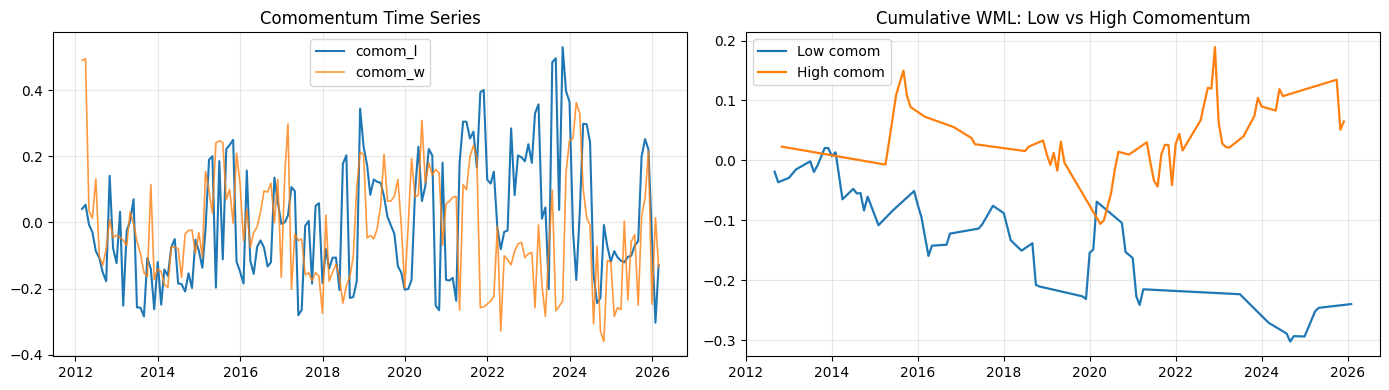

In [4]:

def event_table_by_rank(df: pd.DataFrame, rank_col: str, year_cols: list[str]) -> pd.DataFrame:
    work = df[[rank_col] + year_cols].dropna()
    out = work.groupby(rank_col)[year_cols].mean()
    out.index = [f'rank_{int(i)}' for i in out.index]
    if {'rank_1', f'rank_{int(work[rank_col].max())}'} <= set(out.index):
        hi = out.loc[f'rank_{int(work[rank_col].max())}']
        lo = out.loc['rank_1']
        out.loc['high_minus_low'] = hi - lo
    return out

main_event_table = event_table_by_rank(analysis, 'comom_rank_l', ['year0', 'year1', 'year2', 'year3'])

reg_y1 = nw_ols(analysis, 'year1', ['comom_rank_l'], lags=12)
reg_y2 = nw_ols(analysis, 'year2', ['comom_rank_l'], lags=12)
reg_y1_ctrl = nw_ols(analysis, 'year1', ['comom_rank_l', 'mktret36', 'mktvol36'], lags=12)
reg_y2_ctrl = nw_ols(analysis, 'year2', ['comom_rank_l', 'mktret36', 'mktvol36'], lags=12)

results_table34 = pd.DataFrame([
    {
        'model': 'year1 ~ comom_rank_l',
        'coef_comom': reg_y1['coef'].get('comom_rank_l', np.nan),
        't_comom': reg_y1['t'].get('comom_rank_l', np.nan),
        'nobs': reg_y1['nobs'],
        'rsq': reg_y1['rsq'],
    },
    {
        'model': 'year2 ~ comom_rank_l',
        'coef_comom': reg_y2['coef'].get('comom_rank_l', np.nan),
        't_comom': reg_y2['t'].get('comom_rank_l', np.nan),
        'nobs': reg_y2['nobs'],
        'rsq': reg_y2['rsq'],
    },
    {
        'model': 'year1 ~ comom_rank_l + controls',
        'coef_comom': reg_y1_ctrl['coef'].get('comom_rank_l', np.nan),
        't_comom': reg_y1_ctrl['t'].get('comom_rank_l', np.nan),
        'nobs': reg_y1_ctrl['nobs'],
        'rsq': reg_y1_ctrl['rsq'],
    },
    {
        'model': 'year2 ~ comom_rank_l + controls',
        'coef_comom': reg_y2_ctrl['coef'].get('comom_rank_l', np.nan),
        't_comom': reg_y2_ctrl['t'].get('comom_rank_l', np.nan),
        'nobs': reg_y2_ctrl['nobs'],
        'rsq': reg_y2_ctrl['rsq'],
    },
])

print('Event table (means):')
display(main_event_table)
print('\nRegression summary:')
display(results_table34)

# 必須図1: comomentum時系列
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(analysis.index, analysis['comom_l'], label='comom_l', lw=1.5)
axes[0].plot(analysis.index, analysis['comom_w'], label='comom_w', lw=1.2, alpha=0.8)
axes[0].set_title('Comomentum Time Series')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 必須図2: low vs high 条件の累積WML（1か月先リターンを累積）
lh = analysis[['comom_rank_l', 'wml_next']].dropna().copy()
low = lh[lh['comom_rank_l'] == 1]['wml_next']
high = lh[lh['comom_rank_l'] == 3]['wml_next']
low_cum = (1 + low).cumprod() - 1
high_cum = (1 + high).cumprod() - 1
axes[1].plot(low_cum.index, low_cum.values, label='Low comom', lw=1.6)
axes[1].plot(high_cum.index, high_cum.values, label='High comom', lw=1.6)
axes[1].set_title('Cumulative WML: Low vs High Comomentum')
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()



## Robustness (主要6本)


In [5]:

robust_rows = []

# 1) comom_w 代替
r1 = nw_ols(analysis, 'year1', ['comom_rank_w'], lags=12)
robust_rows.append({'test': 'comom_w_alt', 'coef': r1['coef'].get('comom_rank_w', np.nan), 't': r1['t'].get('comom_rank_w', np.nan), 'nobs': r1['nobs']})

# 2) winner+loser 統合
r2 = nw_ols(analysis, 'year1', ['comom_rank_comb'], lags=12)
robust_rows.append({'test': 'combined_signed_comom', 'coef': r2['coef'].get('comom_rank_comb', np.nan), 't': r2['t'].get('comom_rank_comb', np.nan), 'nobs': r2['nobs']})

# 3) 市場共通相関を残差化
r3 = nw_ols(analysis, 'year1', ['comom_rank_l_resid'], lags=12)
robust_rows.append({'test': 'residualized_comom_l', 'coef': r3['coef'].get('comom_rank_l_resid', np.nan), 't': r3['t'].get('comom_rank_l_resid', np.nan), 'nobs': r3['nobs']})

# 4) サブ期間
midpoint = analysis.index[int(len(analysis) / 2)] if len(analysis) > 0 else None
if midpoint is not None:
    first_half = analysis[analysis.index <= midpoint].copy()
    second_half = analysis[analysis.index > midpoint].copy()
    rf = nw_ols(first_half, 'year12', ['comom_rank_l'], lags=12)
    rs = nw_ols(second_half, 'year12', ['comom_rank_l'], lags=12)
else:
    rf = {'coef': {'comom_rank_l': np.nan}, 't': {'comom_rank_l': np.nan}, 'nobs': 0}
    rs = {'coef': {'comom_rank_l': np.nan}, 't': {'comom_rank_l': np.nan}, 'nobs': 0}
robust_rows.append({'test': 'subperiod_first_half', 'coef': rf['coef'].get('comom_rank_l', np.nan), 't': rf['t'].get('comom_rank_l', np.nan), 'nobs': rf['nobs']})
robust_rows.append({'test': 'subperiod_second_half', 'coef': rs['coef'].get('comom_rank_l', np.nan), 't': rs['t'].get('comom_rank_l', np.nan), 'nobs': rs['nobs']})

# 5) skewness 比較（wml_next）
low_next = analysis.loc[analysis['comom_rank_l'] == 1, 'wml_next'].dropna()
high_next = analysis.loc[analysis['comom_rank_l'] == 3, 'wml_next'].dropna()
robust_rows.append({'test': 'skewness_low_minus_high', 'coef': float(low_next.skew() - high_next.skew()) if len(low_next) > 5 and len(high_next) > 5 else np.nan, 't': np.nan, 'nobs': int(min(len(low_next), len(high_next)))})

# 6) bad-week 頻度比較
low_bad = analysis.loc[analysis['comom_rank_l'] == 1, 'bad_week_freq'].dropna()
high_bad = analysis.loc[analysis['comom_rank_l'] == 3, 'bad_week_freq'].dropna()
robust_rows.append({'test': 'bad_week_freq_high_minus_low', 'coef': float(high_bad.mean() - low_bad.mean()) if len(low_bad) > 0 and len(high_bad) > 0 else np.nan, 't': np.nan, 'nobs': int(min(len(low_bad), len(high_bad)))})

robust_results = pd.DataFrame(robust_rows)

def sign_match(base_sign: float, x: float) -> float:
    if np.isnan(x) or np.isnan(base_sign) or base_sign == 0:
        return np.nan
    return 1.0 if np.sign(x) == np.sign(base_sign) else 0.0

base_coef = results_table34.loc[results_table34['model'] == 'year1 ~ comom_rank_l', 'coef_comom'].iloc[0]
robust_results['sign_match_main'] = robust_results['coef'].apply(lambda v: sign_match(base_coef, v))
sign_match_count = int(np.nansum(robust_results['sign_match_main'].values))
robustness_pass_fail = 'pass' if sign_match_count >= 4 else 'fail'

print('Robustness results:')
display(robust_results)
print('Sign match count:', sign_match_count, '| pass/fail:', robustness_pass_fail)


Robustness results:


test      coef         t  nobs  sign_match_main
0                   comom_w_alt  0.000003  0.001739   157              1.0
1         combined_signed_comom  0.000627  0.337222   157              1.0
2          residualized_comom_l  0.001167  0.892856   133              1.0
3          subperiod_first_half  0.000265  0.415187    85              1.0
4         subperiod_second_half  0.002335  0.918415    60              1.0
5       skewness_low_minus_high  0.907940       NaN    56              1.0
6  bad_week_freq_high_minus_low  0.041370       NaN    53              1.0

Sign match count: 7 | pass/fail: pass



## Investor Extension (流動性サイズ3群)


In [6]:

panel_rows = []
tickers = list(prices_daily.columns)

for dt in analysis.index:
    if dt not in ret12_skip1.index or dt not in dollar_vol_m.index:
        continue
    next_month = dt + pd.offsets.MonthEnd(1)
    if next_month not in ret_m.index:
        continue

    sig = ret12_skip1.loc[dt, tickers].dropna()
    dv = dollar_vol_m.loc[dt, tickers].dropna()
    if len(sig) < 6 or len(dv) < 6:
        continue

    sd = sig.std(ddof=0)
    z = (sig - sig.mean()) / (sd if sd > 0 else 1.0)

    size_rank = dv.rank(method='first')
    size_group = pd.qcut(size_rank, 3, labels=['small', 'mid', 'large'])

    comom_rank = analysis.loc[dt, 'comom_rank_l']
    for tk in tickers:
        if tk not in z.index or tk not in size_group.index:
            continue
        panel_rows.append({
            'signal_month': dt,
            'return_month': next_month,
            'ticker': tk,
            'ret_next': float(ret_m.loc[next_month, tk]),
            'umd_proxy': float(z.loc[tk]),
            'comom_rank': float(comom_rank),
            'size_group': str(size_group.loc[tk]),
        })

panel = pd.DataFrame(panel_rows)

if len(panel) > 0:
    panel = panel.sort_values(['return_month', 'ticker']).reset_index(drop=True)
    panel['size_mid'] = (panel['size_group'] == 'mid').astype(float)
    panel['size_large'] = (panel['size_group'] == 'large').astype(float)
    panel['comom_x_mid'] = panel['comom_rank'] * panel['size_mid']
    panel['comom_x_large'] = panel['comom_rank'] * panel['size_large']

    inv_reg = nw_ols(panel, 'ret_next', ['umd_proxy', 'comom_rank', 'size_mid', 'size_large', 'comom_x_mid', 'comom_x_large'], lags=12)

    b = inv_reg['coef']
    t = inv_reg['t']
    slope_small = b.get('comom_rank', np.nan)
    slope_mid = slope_small + b.get('comom_x_mid', 0.0)
    slope_large = slope_small + b.get('comom_x_large', 0.0)

    investor_results = pd.DataFrame([
        {'group': 'small', 'comom_slope': slope_small, 'interaction_t': np.nan},
        {'group': 'mid', 'comom_slope': slope_mid, 'interaction_t': t.get('comom_x_mid', np.nan)},
        {'group': 'large', 'comom_slope': slope_large, 'interaction_t': t.get('comom_x_large', np.nan)},
    ])
    investor_model_info = {
        'nobs': inv_reg['nobs'],
        'coef': inv_reg['coef'],
        't': inv_reg['t'],
        'rsq': inv_reg['rsq'],
    }
else:
    investor_results = pd.DataFrame(columns=['group', 'comom_slope', 'interaction_t'])
    investor_model_info = {'nobs': 0, 'coef': {}, 't': {}, 'rsq': np.nan}

print('Investor extension results:')
display(investor_results)
print('Investor model nobs:', investor_model_info['nobs'])


Investor extension results:


group  comom_slope  interaction_t
0  small     0.003453            NaN
1    mid     0.006517       1.025249
2  large     0.003096      -0.113551

Investor model nobs: 1512



## External ETF Extension (擬似市場A/B)


In [7]:

def summarize_main_sign(analysis_u: pd.DataFrame, rank_col: str) -> dict:
    r_y1 = nw_ols(analysis_u, 'year1', [rank_col], lags=12)
    r_y2 = nw_ols(analysis_u, 'year2', [rank_col], lags=12)
    return {
        'coef_y1': r_y1['coef'].get(rank_col, np.nan),
        't_y1': r_y1['t'].get(rank_col, np.nan),
        'coef_y2': r_y2['coef'].get(rank_col, np.nan),
        't_y2': r_y2['t'].get(rank_col, np.nan),
        'nobs_y1': r_y1['nobs'],
        'nobs_y2': r_y2['nobs'],
    }

# 擬似市場A: cyclical 6ETF
cyclical = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLY']
full_a = run_pipeline_for_universe(prices_daily[cyclical], volume_daily[cyclical], top_n=3, bottom_n=3, universe_name='pseudo_A_cyclical')
a_analysis = full_a['analysis'].copy()
a_analysis['comom_rank_l'] = rank_buckets(a_analysis['comom_l'], bins=3)
a_sign = summarize_main_sign(a_analysis, 'comom_rank_l')

# 擬似市場B: defensive 3ETF -> Top1/Bottom1
defensive = ['XLP', 'XLU', 'XLV']
full_b = run_pipeline_for_universe(prices_daily[defensive], volume_daily[defensive], top_n=1, bottom_n=1, universe_name='pseudo_B_defensive')
b_analysis = full_b['analysis'].copy()
b_analysis['comom_rank_l'] = rank_buckets(b_analysis['comom_l'], bins=3)
b_sign = summarize_main_sign(b_analysis, 'comom_rank_l')

external_results = pd.DataFrame([
    {'market': 'pseudo_A_cyclical', 'top_bottom': 'Top3/Bottom3', **a_sign},
    {'market': 'pseudo_B_defensive', 'top_bottom': 'Top1/Bottom1', **b_sign},
])

print('External ETF extension results:')
display(external_results)


External ETF extension results:


market    top_bottom   coef_y1     t_y1   coef_y2      t_y2  nobs_y1  nobs_y2
0   pseudo_A_cyclical  Top3/Bottom3 -0.000759 -0.54298 -0.001647 -1.099374      157      145
1  pseudo_B_defensive  Top1/Bottom1 -0.002612 -1.90652 -0.000881 -0.792734      157      145


## Conclusions / Artifact Output


In [8]:

main_coef_y1 = results_table34.loc[results_table34['model'] == 'year1 ~ comom_rank_l', 'coef_comom'].iloc[0]
main_coef_y2 = results_table34.loc[results_table34['model'] == 'year2 ~ comom_rank_l', 'coef_comom'].iloc[0]
main_signs = {
    'year1_coef_sign': 'negative' if main_coef_y1 < 0 else 'non_negative',
    'year2_coef_sign': 'negative' if main_coef_y2 < 0 else 'non_negative',
    'year1_coef': float(main_coef_y1),
    'year2_coef': float(main_coef_y2),
}

investor_extension_result = {
    'nobs': int(investor_model_info.get('nobs', 0)),
    'group_slopes': investor_results.to_dict(orient='records'),
}

external_extension_result = external_results.to_dict(orient='records')

leak_checks = {
    **full['leak_checks'],
    'all_zero': bool(full['leak_checks']['feature_after_target_violations'] == 0 and full['leak_checks']['comom_window_violations'] == 0),
}

summary_obj = {
    'run_datetime': datetime.now().astimezone().isoformat(timespec='seconds'),
    'data_period': {
        'start': str(prices_daily.index.min().date()),
        'end': str(prices_daily.index.max().date()),
    },
    'universe': 'XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY',
    'quantile_rule': {
        'full': 'Top3/Bottom3',
        'pseudo_B_defensive': 'Top1/Bottom1',
    },
    'comom_definition': '52-week residual correlation with equal-weight ETF market factor',
    'main_signs': main_signs,
    'robustness_pass_fail': robustness_pass_fail,
    'robustness_sign_match_count': int(sign_match_count),
    'investor_extension_result': investor_extension_result,
    'external_extension_result': external_extension_result,
    'leak_checks': leak_checks,
}

lines = [
    '# Phase B Summary (Sector ETF Comomentum)',
    '',
    f"- run_datetime: {summary_obj['run_datetime']}",
    f"- data_period: {summary_obj['data_period']['start']} to {summary_obj['data_period']['end']}",
    f"- universe: {summary_obj['universe']}",
    '- quantile_rule:',
    f"  - full: {summary_obj['quantile_rule']['full']}",
    f"  - pseudo_B_defensive: {summary_obj['quantile_rule']['pseudo_B_defensive']}",
    f"- comom_definition: {summary_obj['comom_definition']}",
    f"- main_signs: year1={summary_obj['main_signs']['year1_coef_sign']} ({summary_obj['main_signs']['year1_coef']:.6f}), year2={summary_obj['main_signs']['year2_coef_sign']} ({summary_obj['main_signs']['year2_coef']:.6f})",
    f"- robustness_pass_fail: {summary_obj['robustness_pass_fail']} (sign_match_count={summary_obj['robustness_sign_match_count']})",
    f"- investor_extension_result: nobs={summary_obj['investor_extension_result']['nobs']}",
    '- external_extension_result:',
]
for row in summary_obj['external_extension_result']:
    lines.append(
        f"  - {row['market']}: y1_coef={row['coef_y1']:.6f}, y2_coef={row['coef_y2']:.6f}, nobs_y1={row['nobs_y1']}"
    )

lines.extend([
    f"- leak_checks: feature_after_target_violations={summary_obj['leak_checks']['feature_after_target_violations']}, comom_window_violations={summary_obj['leak_checks']['comom_window_violations']}, all_zero={summary_obj['leak_checks']['all_zero']}",
    '',
    '```json',
    json.dumps(summary_obj, ensure_ascii=False, indent=2),
    '```',
])

SUMMARY_PATH.write_text('\n'.join(lines) + '\n', encoding='utf-8')

print('Summary written to:', SUMMARY_PATH)
print('\nMain signs:', main_signs)
print('Robustness pass/fail:', robustness_pass_fail)
print('Leak checks:', leak_checks)


Summary written to: /Users/kencharoff/workspace/projects/momentum/p02_comomentum/outputs/phase_b/summary.md

Main signs: {'year1_coef_sign': 'non_negative', 'year2_coef_sign': 'non_negative', 'year1_coef': 0.0002100471190937051, 'year2_coef': 0.0002022118455395309}
Robustness pass/fail: pass
Leak checks: {'feature_after_target_violations': 0, 'comom_window_violations': 0, 'all_zero': True}
